# Diffusion with Non-orthogonal Correction Term and Non-orthogonal Gradient Algorithm

Here we solve the equation
$$
-\nabla^2 \phi = 0
$$
on a trapezoidal grid defined by a $45-45-90$ triangle.

Dirichlet conditions are enforced at the left and bottom, and right and top.

Patankar under relaxation ($\lambda^\phi < 1$) is applied during smoothing.

In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the system

refinement = 10
dx = 0.3/(refinement-1)

# Dirichlet constants
phi_left, phi_bottom, phi_right, phi_top = 300.0, 300.0, 300.0, 500.0

# Vertices (from bottom left to top right)
vertices = {}
count = 0
for y in np.arange(0,0.2,np.round(0.2/(refinement-1),10)):
    for x in np.arange(0,0.3,np.round(0.3/(refinement-1),10)):
        vertices[count] = np.array([x+y,y])
        count += 1

# Cells (as [vertex1, vertex2, vertex3, vertex4])
cells = {}
boundary_left = []
boundary_bottom = []
boundary_right = []
boundary_top = []
boundary_corner_1 = []
boundary_corner_2 = []
boundary_corner_3 = []
boundary_corner_4 = []
vert = 0
for i in range((refinement-1) * (refinement-1)):
    cells[i] = [vertices[vert], vertices[vert+1], vertices[vert+refinement], vertices[vert+refinement+1]]
    if (vert + 2) % refinement == 0 and vert != 0:
        vert += 2
    else:
        vert += 1
    if i < refinement - 1 and i % (refinement-1)!=0 and (i+1) % (refinement-1)!=0:
        boundary_bottom.append(i)
    elif (i % (refinement-1) == 0) and i >= refinement - 1 and i < (refinement - 1) * (refinement - 2):
        boundary_left.append(i)
    elif ((i+1) % (refinement-1) == 0) and i >= refinement - 1 and i < (refinement - 1) * (refinement - 2):
        boundary_right.append(i)
    elif (i > (refinement - 1) * (refinement - 2)) and i % (refinement-1)!=0 and (i+1) % (refinement-1)!=0:
        boundary_top.append(i)
    elif (i < refinement - 1) and (i % (refinement-1)==0):
        boundary_corner_1.append(i)
    elif (i < refinement - 1) and ((i+1) % (refinement - 1)==0):
        boundary_corner_2.append(i)
    elif (i >= (refinement - 1) * (refinement - 2)) and i % (refinement-1)==0:
        boundary_corner_3.append(i)
    elif (i > (refinement - 1) * (refinement - 2)) and (i+1) % (refinement-1)==0:
        boundary_corner_4.append(i)
    
# Centroids (must be parallelograms) (A+B/2,C+D/2)
cell_centroids = {}
for cell in cells.keys():
    cell_centroids[cell] = np.array([
        0.5*(cells[cell][0][0] + cells[cell][3][0]),
        0.5*(cells[cell][0][1] + cells[cell][3][1])
    ])

# Neighbors as [W, E, N, S]
neighbors = {}
for cell in cells.keys():
    if cell in boundary_corner_1:
        neighbors[cell] = [None, cell + 1, cell + refinement - 1, None]
    elif cell in boundary_corner_2:
        neighbors[cell] = [cell - 1, None, cell + refinement - 1, None]
    elif cell in boundary_corner_3:
        neighbors[cell] = [None, cell + 1, None, cell - refinement + 1]
    elif cell in boundary_corner_4:
        neighbors[cell] = [cell - 1, None, None, cell - refinement + 1]
    elif cell in boundary_left:
        neighbors[cell] = [None, cell + 1, cell + refinement - 1, cell - refinement + 1]
    elif cell in boundary_bottom:
        neighbors[cell] = [cell - 1, cell + 1, cell + refinement - 1, None]
    elif cell in boundary_right:
        neighbors[cell] = [cell - 1, None, cell + refinement - 1, cell - refinement + 1]
    elif cell in boundary_top:
        neighbors[cell] = [cell - 1, cell + 1, None, cell - refinement + 1]
    else:
        neighbors[cell] = [cell - 1, cell + 1, cell + refinement - 1, cell - refinement + 1]

# Normals
n_left, n_bottom, n_right, n_top = np.array([-0.2,0.2])/np.sqrt(0.2**2+0.2**2), np.array([0,-1.0]), np.array([0.2,-0.2])/np.sqrt(0.2**2+0.2**2), np.array([0,1.0])

e_left, e_bottom, e_right, e_top = np.array([-1.0,0]), np.array([-0.2,-0.2])/np.sqrt(0.2**2+0.2**2), np.array([1.0,0]), np.array([0.2,0.2])/np.sqrt(0.2**2+0.2**2)

S_top, S_bottom = dx, dx
S_right, S_left = np.sqrt(2)*dx, np.sqrt(2)*dx

E_left, E_right, E_top, E_bottom = S_left/np.dot(n_left,e_left), S_right/np.dot(n_right,e_right), S_top/np.dot(n_top,e_top), S_bottom/np.dot(n_bottom,e_bottom)

# Because the mesh is uniform, we can predefine distances to centroids. Define volumes, face surfaces, etc.
temp_C = cell_centroids[10]
temp_W = cell_centroids[9]
temp_E = cell_centroids[11]
temp_N = cell_centroids[19]
temp_S = cell_centroids[1]

dx_left = np.sqrt((temp_W[0] - temp_C[0])**2 + (temp_W[1] - temp_C[0])**2)
dx_right = np.sqrt((temp_E[0] - temp_C[0])**2 + (temp_E[1] - temp_C[1])**2)
dy_bottom = np.sqrt((temp_S[0] - temp_C[0])**2 + (temp_S[1] - temp_C[1])**2)
dy_top = np.sqrt((temp_N[0] - temp_C[0])**2 + (temp_N[1] - temp_C[1])**2)

Vc = dx**2

In [3]:
# Assembly Matrix

A = np.zeros(((refinement - 1)*(refinement - 1),(refinement - 1)*(refinement - 1)))
b = np.zeros((refinement - 1)*(refinement - 1))

for i in range((refinement - 1) * (refinement - 1)):
    # corner 1
    if i in boundary_corner_1:
        W, E, N, S = neighbors[i]
        A[i,E] = -E_left/dx_left
        A[i,N] = -E_top/dy_top
        A[i,i] = -(A[i,E] + A[i,N]) + 2*E_bottom/dy_bottom + 2*E_left/dx_left
        b[i] = 2*E_bottom*phi_bottom/dy_bottom + 2*E_left*phi_left/dx_left
    # corner 2
    elif i in boundary_corner_2:
        W, E, N, S = neighbors[i]
        A[i,W] = -E_left/dx_left
        A[i,N] = -E_top/dy_top
        A[i,i] = -(A[i,W] + A[i,N]) + 2*E_bottom/dy_bottom + 2*E_right/dx_right
        b[i] = 2*E_bottom*phi_bottom/dy_bottom + 2*E_right*phi_right/dx_right
    # corner 3
    elif i in boundary_corner_3:
        W, E, N, S = neighbors[i]
        A[i,E] = -E_right/dx_right
        A[i,S] = -E_bottom/dy_bottom
        A[i,i] = -(A[i,E] + A[i,S]) + 2*E_left/dx_left + 2*E_top/dy_top
        b[i] = 2*E_left*phi_left/dx_left + 2*E_top*phi_top/dy_top
    # corner 4
    elif i in boundary_corner_4:
        W, E, N, S = neighbors[i]
        A[i,W] = -E_left/dx_left
        A[i,S] = -E_bottom/dy_bottom
        A[i,i] = -(A[i,W] + A[i,S]) + 2*E_right/dx_right + 2*E_top/dy_top
        b[i] = 2*E_right*phi_right/dx_right + 2*E_top*phi_top/dy_top
    # left
    elif i in boundary_left:
        W, E, N, S = neighbors[i]
        A[i,E] = -E_right/dx_right
        A[i,N] = -E_top/dy_top
        A[i,S] = -E_bottom/dy_bottom
        A[i,i] = -(A[i,E] + A[i,N] + A[i,S]) + 2*E_left/dx_left
        b[i] = 2*E_left*phi_left/dx_left
    # bottom
    elif i in boundary_bottom:
        W, E, N, S = neighbors[i]
        A[i,W] = -E_left/dx_left
        A[i,E] = -E_right/dx_right
        A[i,N] = -E_top/dy_top
        A[i,i] = -(A[i,W] + A[i,E] + A[i,N]) + 2*E_bottom/dy_bottom
        b[i] = 2*E_bottom*phi_bottom/dy_bottom
    # right
    elif i in boundary_right:
        W, E, N, S = neighbors[i]
        A[i,W] = -E_left/dx_left
        A[i,N] = -E_top/dy_top
        A[i,S] = -E_bottom/dy_bottom
        A[i,i] = -(A[i,W] + A[i,N] + A[i,S]) + 2*E_right/dx_right
        b[i] = 2*E_right*phi_right/dx_right
    # top
    elif i in boundary_top:
        W, E, N, S = neighbors[i]
        A[i,W] = -E_left/dx_left
        A[i,E] = -E_right/dx_right
        A[i,S] = -E_bottom/dy_bottom
        A[i,i] = -(A[i,W] + A[i,E] + A[i,S]) + 2*E_top/dy_top
        b[i] = 2*E_top*phi_top/dy_top
    # interior
    else:
        W, E, N, S = neighbors[i]
        A[i,W] = -E_left/dx_left
        A[i,E] = -E_right/dx_right
        A[i,N] = -E_top/dy_top
        A[i,S] = -E_bottom/dy_bottom
        A[i,i] = -(A[i,W] + A[i,E] + A[i,N] + A[i,S])

In [4]:
# Pseudocode: implicit under-relaxation

# GaussSeidel(A, b, previous, correction):
#   A* <- L + D/l + U
#   b* <- b + correction + (1-l)/l * D * previous
#   ---smoothing---

l_alpha = 0.75
tol = 1e-10

# I totally abuse this function here; global iteration could have been put all in one loop
def gaussSeidel(A, b, previous, correction, init_guess, max_iter=10):
    global l_alpha

    # initial guess
    T = init_guess*0 + init_guess
    assert T.shape[0] == A.shape[0]

    D = np.diag(np.diag(A))
    A_prime = (np.tril(A) - D) + (D / l_alpha) + (np.triu(A) - D)
    b_prime = np.add(np.add(b, correction), (1-l_alpha)/l_alpha * D@previous)

    assert b_prime.shape[0] == A_prime.shape[0]

    for i in range(A_prime.shape[0]):
        sumt = 0
        for j in range(A_prime.shape[0]):
            if j != i:
                sumt += A_prime[i,j] * T[j]
        T[i] = (b_prime[i] - sumt) / A_prime[i,i] 

    iter = 1
    while (iter < max_iter) and (np.linalg.norm(b+correction - A@T)>tol):
        for i in range(A_prime.shape[0]):
            sumt = 0
            for j in range(A_prime.shape[0]):
                if j != i:
                    sumt += A[i,j] * T[j]
            T[i] = (b_prime[i] - sumt) / A[i,i] 
        iter += 1
    return T, (b+correction)-A@T

In [59]:
# Gradient Algorithm

def getCellGradients(phi):
    # temporarily store face data as [w, e, n, s]
    faces = {}
    Dphi = {}
    # iter 1
    for i in range(len(phi)):
        W, E, N, S = neighbors[i]
        if i in boundary_corner_1:
            phi_w = phi_left
            phi_e = 0.5*(phi[E] + phi[i])
            phi_n = 0.5*(phi[N] + phi[i])
            phi_s = phi_bottom
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_corner_2:
            phi_w = 0.5*(phi[W] + phi[i])
            phi_e = phi_right
            phi_n = 0.5*(phi[N] + phi[i])
            phi_s = phi_bottom
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_corner_3:
            phi_w = phi_left
            phi_e = 0.5*(phi[E] + phi[i])
            phi_n = phi_top
            phi_s = 0.5*(phi[S] + phi[i])
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_corner_4:
            phi_w = 0.5*(phi[W] + phi[i])
            phi_e = phi_right
            phi_n = phi_top
            phi_s = 0.5*(phi[S] + phi[i])
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_left:
            phi_w = phi_left
            phi_e = 0.5*(phi[E] + phi[i])
            phi_n = 0.5*(phi[N] + phi[i])
            phi_s = 0.5*(phi[S] + phi[i])
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_bottom:
            phi_w = 0.5*(phi[W] + phi[i])
            phi_e = 0.5*(phi[E] + phi[i])
            phi_n = 0.5*(phi[N] + phi[i])
            phi_s = phi_bottom
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_right:
            phi_w = 0.5*(phi[W] + phi[i])
            phi_e = phi_right
            phi_n = 0.5*(phi[N] + phi[i])
            phi_s = 0.5*(phi[S] + phi[i])
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_top:
            phi_w = 0.5*(phi[W] + phi[i])
            phi_e = 0.5*(phi[E] + phi[i])
            phi_n = phi_top
            phi_s = 0.5*(phi[S] + phi[i])
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        else:
            phi_w = 0.5*(phi[W] + phi[i])
            phi_e = 0.5*(phi[E] + phi[i])
            phi_n = 0.5*(phi[N] + phi[i])
            phi_s = 0.5*(phi[S] + phi[i])
            faces[i] = [phi_w, phi_e, phi_n, phi_s]
            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)

    # update (iter 2)
    for i in range(len(phi)):
        W, E, N, S = neighbors[i]
        v1, v2, v3, v4 = cells[i]
        if i in boundary_corner_1:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w
            phi_e = phi_e + 0.5*np.dot((Dphi[E] + Dphi[i]), (np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]) - (cell_centroids[i] + np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]))))
            phi_n = phi_n + 0.5*np.dot((Dphi[N] + Dphi[i]), (np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]))))
            phi_s = phi_s

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_corner_2:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w + 0.5*np.dot((Dphi[W] + Dphi[i]), (np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]))))
            phi_e = phi_e
            phi_n = phi_n + 0.5*np.dot((Dphi[N] + Dphi[i]), (np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]))))
            phi_s = phi_s

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_corner_3:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w
            phi_e = phi_e + 0.5*np.dot((Dphi[E] + Dphi[i]), (np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]) - (cell_centroids[i] + np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]))))
            phi_n = phi_n
            phi_s = phi_s + 0.5*np.dot((Dphi[S] + Dphi[i]), (np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]))))

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_corner_4:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w + 0.5*np.dot((Dphi[W] + Dphi[i]), (np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]))))
            phi_e = phi_e
            phi_n = phi_n
            phi_s = phi_s + 0.5*np.dot((Dphi[S] + Dphi[i]), (np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]))))

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_left:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w
            phi_e = phi_e + 0.5*np.dot((Dphi[E] + Dphi[i]), (np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]) - (cell_centroids[i] + np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]))))
            phi_n = phi_n + 0.5*np.dot((Dphi[N] + Dphi[i]), (np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]))))
            phi_s = phi_s + 0.5*np.dot((Dphi[S] + Dphi[i]), (np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]))))

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_bottom:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w + 0.5*np.dot((Dphi[W] + Dphi[i]), (np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]))))
            phi_e = phi_e + 0.5*np.dot((Dphi[E] + Dphi[i]), (np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]) - (cell_centroids[i] + np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]))))
            phi_n = phi_n + 0.5*np.dot((Dphi[N] + Dphi[i]), (np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]))))
            phi_s = phi_s

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_right:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w + 0.5*np.dot((Dphi[W] + Dphi[i]), (np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]))))
            phi_e = phi_e
            phi_n = phi_n + 0.5*np.dot((Dphi[N] + Dphi[i]), (np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]))))
            phi_s = phi_s + 0.5*np.dot((Dphi[S] + Dphi[i]), (np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]))))

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        elif i in boundary_top:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w + 0.5*np.dot((Dphi[W] + Dphi[i]), (np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]))))
            phi_e = phi_e + 0.5*np.dot((Dphi[E] + Dphi[i]), (np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]) - (cell_centroids[i] + np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]))))
            phi_n = phi_n
            phi_s = phi_s + 0.5*np.dot((Dphi[S] + Dphi[i]), (np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]))))

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        else:
            phi_w, phi_e, phi_n, phi_s = faces[i]
            phi_w = phi_w + 0.5*np.dot((Dphi[W] + Dphi[i]), (np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v4[0]),0.5*(v1[1]+v4[1])]))))
            phi_e = phi_e + 0.5*np.dot((Dphi[E] + Dphi[i]), (np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]) - (cell_centroids[i] + np.array([0.5*(v2[0]+v3[0]),0.5*(v2[1]+v3[1])]))))
            phi_n = phi_n + 0.5*np.dot((Dphi[N] + Dphi[i]), (np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]) - (cell_centroids[i] + np.array([0.5*(v3[0]+v4[0]),0.5*(v3[1]+v4[1])]))))
            phi_s = phi_s + 0.5*np.dot((Dphi[S] + Dphi[i]), (np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]) - (cell_centroids[i] + np.array([0.5*(v1[0]+v2[0]),0.5*(v1[1]+v2[1])]))))

            Dphi[i] = (1/Vc)*(phi_w*S_left*n_left
                              + phi_e*S_right*n_right
                              + phi_n*S_top*n_top
                              + phi_s*S_bottom*n_bottom)
        
        return Dphi

In [60]:
# Non-orthogonal correction function
# Using: 

def crossDiffusionCorrection(Dphi, phi):
    correction = np.zeros((refinement - 1)*(refinement - 1))

    for i in Dphi.keys():
        W, E, N, S = neighbors[i]
        v1, v2, v3, v4 = cells[i]
        if i in boundary_corner_1:
            # we need gradient at w and s faces
            db_lin = dx/2
            db_incl = np.sqrt(dx**2 + dx**2)/2
            dn1_N = np.sqrt((cell_centroids[N][0]-v4[0])**2 + (cell_centroids[N][1]-v4[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v4[0])**2 + (cell_centroids[i][1]-v4[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v2[0])**2 + (cell_centroids[i][1]-v2[1])**2)
            dn2_E = np.sqrt((cell_centroids[E][0]-v2[0])**2 + (cell_centroids[E][1]-v2[1])**2)
            dn3_C = np.sqrt((cell_centroids[i][0]-v1[0])**2 + (cell_centroids[i][1]-v1[1])**2)
            phi_n1 = (2*phi_left/db_incl + phi[i]/dn1_C + phi[N]/dn1_N)/(2/db_incl + 1/dn1_C + 1/dn1_N)
            phi_n2 = (2*phi_left/db_lin + phi[i]/dn2_C + phi[E]/dn2_E)/(2/db_lin + 1/dn2_C + 1/dn2_E)
            phi_n3 = (phi_left/db_incl + phi_bottom/db_lin + phi[i]/dn3_C)/(1/db_incl + 1/db_lin + 1/dn3_C)
            Dphi_b_left = (1/Vc)*((2*phi_left-phi[i])*S_left*n_left +
                             phi_n1*S_top*n_top + 
                             phi[i]*S_right*n_right + 
                             phi_n3*S_bottom*n_bottom)
            Dphi_b_bottom = (1/Vc)*((2*phi_bottom-phi[i])*S_bottom*n_bottom +
                             phi_n3*S_left*n_left + 
                             phi[i]*S_top*n_top + 
                             phi_n2*S_right*n_right)

            correction[i] = (
                np.dot((Dphi_b_left), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                0.5*np.dot((Dphi[i] + Dphi[E]), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                0.5*np.dot((Dphi[i] + Dphi[N]), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                np.dot((Dphi_b_bottom), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_corner_2:
            # we need gradient at e and s faces
            db_lin = dx/2
            db_incl = np.sqrt(dx**2 + dx**2)/2
            dn1_N = np.sqrt((cell_centroids[N][0]-v3[0])**2 + (cell_centroids[N][1]-v3[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v3[0])**2 + (cell_centroids[i][1]-v3[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v1[0])**2 + (cell_centroids[i][1]-v1[1])**2)
            dn2_W = np.sqrt((cell_centroids[W][0]-v1[0])**2 + (cell_centroids[W][1]-v1[1])**2)
            dn3_C = np.sqrt((cell_centroids[i][0]-v2[0])**2 + (cell_centroids[i][1]-v2[1])**2)
            phi_n1 = (2*phi_right/db_incl + phi[i]/dn1_C + phi[N]/dn1_N)/(2/db_incl + 1/dn1_C + 1/dn1_N)
            phi_n2 = (2*phi_bottom/db_lin + phi[i]/dn2_C + phi[W]/dn2_W)/(2/db_lin + 1/dn2_C + 1/dn2_W)
            phi_n3 = (phi_right/db_incl + phi_bottom/db_lin + phi[i]/dn3_C)/(1/db_incl + 1/db_lin + 1/dn3_C)
            Dphi_b_right = (1/Vc)*(
                (2*phi_right-phi[i])*S_right*n_right +
                phi_n1*S_top*n_top + 
                phi_n3*S_bottom*n_bottom +
                phi[i]*S_left*n_left
            )
            Dphi_b_bottom = (1/Vc)*(
                (2*phi_bottom-phi[i])*S_bottom*n_bottom +
                phi_n3*S_right*n_right +
                phi_n2*S_left*n_left +
                phi[i]*S_top*n_top
            )

            correction[i] = (
                0.5*np.dot((Dphi[i] + Dphi[W]), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                np.dot((Dphi_b_right), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                0.5*np.dot((Dphi[i] + Dphi[N]), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                np.dot((Dphi_b_bottom), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_corner_3:
            # we need gradient at w and t faces
            db_lin = dx/2
            db_incl = np.sqrt(dx**2 + dx**2)/2
            dn1_E = np.sqrt((cell_centroids[E][0]-v3[0])**2 + (cell_centroids[E][1]-v3[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v3[0])**2 + (cell_centroids[i][1]-v3[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v1[0])**2 + (cell_centroids[i][1]-v1[1])**2)
            dn2_S = np.sqrt((cell_centroids[S][0]-v1[0])**2 + (cell_centroids[S][1]-v1[1])**2)
            dn3_C = np.sqrt((cell_centroids[i][0]-v4[0])**2 + (cell_centroids[i][1]-v4[1])**2)
            phi_n1 = (2*phi_top/db_lin + phi[i]/dn1_C + phi[E]/dn1_E)/(2/db_lin + 1/dn1_C + 1/dn1_E)
            phi_n2 = (2*phi_left/db_incl + phi[i]/dn2_C + phi[S]/dn2_S)/(2/db_incl + 1/dn2_C + 1/dn2_S)
            phi_n3 = (phi_left/db_incl + phi_top/db_lin + phi[i]/dn3_C)/(1/db_incl + 1/db_lin + 1/dn3_C)
            Dphi_b_top = (1/Vc)*(
                (2*phi_top-phi[i])*S_top*n_top +
                phi_n1*S_right*n_right +
                phi_n3*S_left*n_left +
                phi[i]*S_bottom*n_bottom
            )
            Dphi_b_left = (1/Vc)*(
                (2*phi_left-phi[i])*S_left*n_left +
                phi_n3*S_top*n_top +
                phi_n2*S_bottom*n_bottom +
                phi[i]*S_right*n_right
            )

            correction[i] = (
                np.dot((Dphi_b_left), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                0.5*np.dot((Dphi[i] + Dphi[E]), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                np.dot((Dphi_b_top), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                0.5*np.dot((Dphi[i] + Dphi[S]), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_corner_4:
            # we need gradient at e and t faces
            db_lin = dx/2
            db_incl = np.sqrt(dx**2 + dx**2)/2
            dn1_W = np.sqrt((cell_centroids[W][0]-v4[0])**2 + (cell_centroids[W][1]-v4[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v4[0])**2 + (cell_centroids[i][1]-v4[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v2[0])**2 + (cell_centroids[i][1]-v2[1])**2)
            dn2_S = np.sqrt((cell_centroids[S][0]-v2[0])**2 + (cell_centroids[S][1]-v2[1])**2)
            dn3_C = np.sqrt((cell_centroids[i][0]-v3[0])**2 + (cell_centroids[i][1]-v3[1])**2)
            phi_n1 = (2*phi_top/db_lin + phi[i]/dn1_C + phi[W]/dn1_W)/(2/db_lin + 1/dn1_C + 1/dn1_W)
            phi_n2 = (2*phi_right/db_incl + phi[i]/dn2_C + phi[S]/dn2_S)/(2/db_incl + 1/dn2_C + 1/dn2_S)
            phi_n3 = (phi_right/db_incl + phi_top/db_lin + phi[i]/dn3_C)/(1/db_incl + 1/db_lin + 1/dn3_C)
            Dphi_b_top = (1/Vc)*(
                (2*phi_top-phi[i])*S_top*n_top +
                phi_n1*S_left*n_left +
                phi_n3*S_right*n_right +
                phi[i]*S_bottom*n_bottom
            )
            Dphi_b_right = (1/Vc)*(
                (2*phi_right-phi[i])*S_right*n_right +
                phi_n3*S_top*n_top +
                phi_n2*S_bottom*n_bottom +
                phi[i]*S_left*n_left
            )

            correction[i] = (
                0.5*np.dot((Dphi[i] + Dphi[W]), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                np.dot((Dphi_b_right), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                np.dot((Dphi_b_top), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                0.5*np.dot((Dphi[i] + Dphi[S]), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_left:
            # we need gradient at w face
            db = np.sqrt(dx**2 + dx**2)/2
            dn1_N = np.sqrt((cell_centroids[N][0]-v4[0])**2 + (cell_centroids[N][1]-v4[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v4[0])**2 + (cell_centroids[i][1]-v4[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v1[0])**2 + (cell_centroids[i][1]-v1[1])**2)
            dn2_S = np.sqrt((cell_centroids[S][0]-v1[0])**2 + (cell_centroids[S][1]-v1[1])**2)
            phi_n1 = (2*phi_left/db + phi[i]/dn1_C + phi[N]/dn1_N)/(2/db + 1/dn1_C + 1/dn1_N)
            phi_n2 = (2*phi_left/db + phi[i]/dn2_C + phi[S]/dn2_S)/(2/db + 1/dn2_C + 1/dn2_S)
            Dphi_b = (1/Vc)*((2*phi_left-phi[i])*S_left*n_left +
                             phi_n1*S_top*n_top + 
                             phi[i]*S_right*n_right + 
                             phi_n2*S_bottom*n_bottom)

            correction[i] = (
                np.dot((Dphi_b), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                0.5*np.dot((Dphi[i] + Dphi[E]), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                0.5*np.dot((Dphi[i] + Dphi[N]), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                0.5*np.dot((Dphi[i] + Dphi[S]), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_bottom:
            # we need gradient at s face
            db = dx/2
            dn1_W = np.sqrt((cell_centroids[W][0]-v1[0])**2 + (cell_centroids[W][1]-v1[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v1[0])**2 + (cell_centroids[i][1]-v1[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v2[0])**2 + (cell_centroids[i][1]-v2[1])**2)
            dn2_E = np.sqrt((cell_centroids[E][0]-v2[0])**2 + (cell_centroids[E][1]-v2[1])**2)
            phi_n1 = (2*phi_bottom/db + phi[i]/dn1_C + phi[W]/dn1_W)/(2/db + 1/dn1_C + 1/dn1_W)
            phi_n2 = (2*phi_bottom/db + phi[i]/dn2_C + phi[E]/dn2_E)/(2/db + 1/dn2_C + 1/dn2_E)
            Dphi_b = (1/Vc)*((2*phi_bottom-phi[i])*S_bottom*n_bottom +
                             phi_n1*S_left*n_left + 
                             phi[i]*S_top*n_top + 
                             phi_n2*S_right*n_right)

            correction[i] = (
                0.5*np.dot((Dphi[i] + Dphi[W]), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                0.5*np.dot((Dphi[i] + Dphi[E]), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                0.5*np.dot((Dphi[i] + Dphi[N]), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                np.dot((Dphi_b), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_right:
            # we need gradient at e face
            db = np.sqrt(dx**2 + dx**2)/2
            dn1_N = np.sqrt((cell_centroids[N][0]-v3[0])**2 + (cell_centroids[N][1]-v3[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v3[0])**2 + (cell_centroids[i][1]-v3[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v2[0])**2 + (cell_centroids[i][1]-v2[1])**2)
            dn2_S = np.sqrt((cell_centroids[S][0]-v2[0])**2 + (cell_centroids[S][1]-v2[1])**2)
            phi_n1 = (2*phi_right/db + phi[i]/dn1_C + phi[N]/dn1_N)/(2/db + 1/dn1_C + 1/dn1_N)
            phi_n2 = (2*phi_right/db + phi[i]/dn2_C + phi[S]/dn2_S)/(2/db + 1/dn2_C + 1/dn2_S)
            Dphi_b = (1/Vc)*((2*phi_right-phi[i])*S_right*n_right +
                             phi_n1*S_top*n_top + 
                             phi[i]*S_left*n_left + 
                             phi_n2*S_bottom*n_bottom)

            correction[i] = (
                0.5*np.dot((Dphi[i] + Dphi[W]), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                np.dot((Dphi_b), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                0.5*np.dot((Dphi[i] + Dphi[N]), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                0.5*np.dot((Dphi[i] + Dphi[S]), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        elif i in boundary_top:
            # we need gradient at t face
            db = dx/2
            dn1_W = np.sqrt((cell_centroids[W][0]-v4[0])**2 + (cell_centroids[W][1]-v4[1])**2)
            dn1_C = np.sqrt((cell_centroids[i][0]-v4[0])**2 + (cell_centroids[i][1]-v4[1])**2)
            dn2_C = np.sqrt((cell_centroids[i][0]-v3[0])**2 + (cell_centroids[i][1]-v3[1])**2)
            dn2_E = np.sqrt((cell_centroids[E][0]-v3[0])**2 + (cell_centroids[E][1]-v3[1])**2)
            phi_n1 = (2*phi_top/db + phi[i]/dn1_C + phi[W]/dn1_W)/(2/db + 1/dn1_C + 1/dn1_W)
            phi_n2 = (2*phi_top/db + phi[i]/dn2_C + phi[E]/dn2_E)/(2/db + 1/dn2_C + 1/dn2_E)
            Dphi_b = (1/Vc)*((2*phi_top-phi[i])*S_top*n_top +
                             phi_n1*S_left*n_left + 
                             phi[i]*S_bottom*n_bottom + 
                             phi_n2*S_right*n_right)

            correction[i] = (
                0.5*np.dot((Dphi[i] + Dphi[W]), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                0.5*np.dot((Dphi[i] + Dphi[E]), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                np.dot((Dphi_b), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                0.5*np.dot((Dphi[i] + Dphi[S]), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
        else:
            correction[i] = (
                0.5*np.dot((Dphi[i] + Dphi[W]), n_left-(e_left/np.dot(e_left,n_left)))*S_left + 
                0.5*np.dot((Dphi[i] + Dphi[E]), n_right-(e_right/np.dot(e_right,n_right)))*S_right +
                0.5*np.dot((Dphi[i] + Dphi[N]), n_top-(e_top/np.dot(e_top,n_top)))*S_top +
                0.5*np.dot((Dphi[i] + Dphi[S]), n_bottom-(e_bottom/np.dot(e_bottom,n_bottom)))*S_bottom
            )
    
    return correction
    

In [67]:
# Pseudocode: non-orthogonal correction

# System = A, b

# correction <- array(0)
# previous <- array(0)

# while not converged do:
#   phi*, resid <- GaussSeidel(A, b, previous, correction)
#   Dphi* <- getCellGradients(phi*)
#   correction <- crossDiffusionCorrection(Dphi, phi)
#   if resid < tol, exit

# phi = np.zeros((refinement - 1)*(refinement - 1))



residuals = []
correction = np.zeros((refinement - 1)*(refinement - 1))
previous = np.zeros((refinement - 1)*(refinement - 1))

tol = 3.2e-12
converged = False
iter_count = 0
while not converged:
    phi, resid = gaussSeidel(A, b, previous=previous, correction=correction, init_guess=previous, max_iter=1)
    Dphi = getCellGradients(phi)
    correction = crossDiffusionCorrection(Dphi, phi)
    norm_res = np.linalg.norm(resid)
    if norm_res < tol:
        converged = True
    previous = phi
    iter_count += 1
    residuals.append(norm_res)

Text(0, 0.5, 'Normalized Residual')

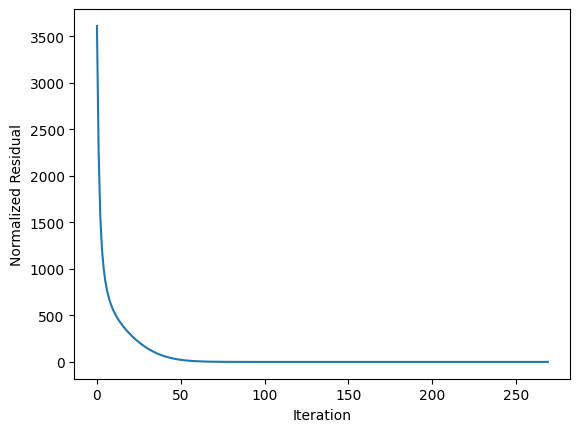

In [68]:
# Plot the residuals

fig,ax = plt.subplots()
ax.plot(np.arange(0,iter_count,1),residuals)
ax.set_xlabel("Iteration")
ax.set_ylabel("Normalized Residual")

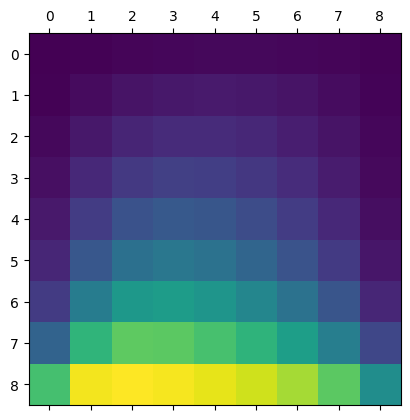

In [69]:
# Viz

plt.matshow(phi.reshape(((refinement-1),(refinement-1))))

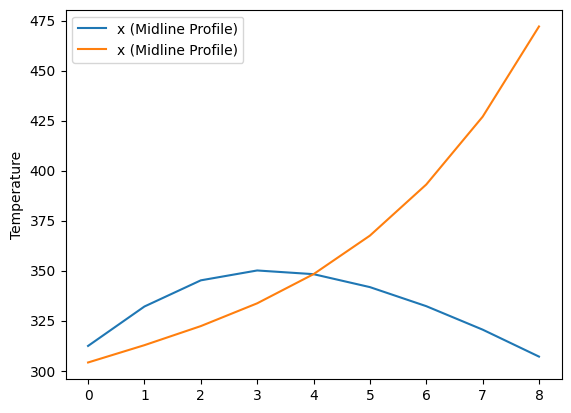

In [70]:
# Temperature Profiles

M = phi.reshape(((refinement - 1),(refinement - 1)))
x_profile = M[4,:]
y_profile = M[:,4]
fig, ax = plt.subplots()
ax.plot(x_profile,label='x (Midline Profile)')
ax.plot(y_profile,label='x (Midline Profile)')
ax.set_ylabel('Temperature')
ax.legend()